# Probit regression

Testing probit regression with identity covariance

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
from time import time

import cvxpy as cv
from statsmodels.discrete.discrete_model import Probit
import sklearn.linear_model as linear_model
from scipy.special import erfcinv
from scipy.stats import norm

from state_evolution.models.probit_regression import ProbitRegression # logistic regression task
from state_evolution.models.logistic_regression import LogisticRegression # logistic regression task
from state_evolution.models.bayes_optimal_probit import BayesOptimalProbit
from state_evolution.algorithms.state_evolution import StateEvolution # Standard SP iteration
from state_evolution.auxiliary.utility import *
from state_evolution.data_models.custom import Custom # Custom data model. You input the covariances

sys.path.append('../state-evolution-erm-logistic/')
import core.se.solve_se as solve_se

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# empirical probit 

def get_empirical_probit(X, y, lambda_):
    w = cv.Variable(d)
    error = - cv.sum(cv.log_normcdf(cv.multiply(y, X @ w))) + lambda_ / 2 * cv.sum_squares(w)
    obj = cv.Minimize(error)
    prob = cv.Problem(obj)
    prob.solve()

    weight = w.value
    return weight

def run_statsmodel_probit(X, y, lambda_):
    y_probit = (1. + y) / 2.
    pr = Probit(y_probit, X)
    res = pr.fit()
    return res.params
    

### Running as a function of alpha 

Fix the level, compute the calibration

In [7]:
# FOR PROBIT 

alpha_range  = np.linspace(10.0, 100.0, 10)
sigma   = 2.0
lambda_ = 0.0

pr_m_list, pr_q_list = [], []

for alpha in alpha_range:
    print(alpha)
    retour = solve_se.solve_SE(alpha, model='probit', lambd=lambda_, sigma=sigma, precision=1e-4)
    print('done with se')
    
    m, q = retour['m'], retour['q']
    
    pr_m_list.append(m)
    pr_q_list.append(q)  

10.0
choice overlap:final
min gen: id:50 val:3.906e-01
{'m': 0.5404717586987691, 'q': 0.5142799098843992, 'Q': 0.6953576995965118, 'm_hat': 2.697303023539493, 'q_hat': 5.545316214343918, 'Q_hat': -0.6162746147769023}
min diff: id:50 val:3.906e-01
{'m': 0.5404717586987691, 'q': 0.5142799098843992, 'Q': 0.6953576995965118, 'm_hat': 2.697303023539493, 'q_hat': 5.545316214343918, 'Q_hat': -0.6162746147769023}
final: id:50 val:3.906e-01
{'m': 0.5404717586987691, 'q': 0.5142799098843992, 'Q': 0.6953576995965118, 'm_hat': 2.697303023539493, 'q_hat': 5.545316214343918, 'Q_hat': -0.6162746147769023}
done with se
20.0
choice overlap:final
min gen: id:50 val:3.747e-01
{'m': 0.5188440550775877, 'q': 0.3662268860794946, 'Q': 0.44893462516896987, 'm_hat': 5.627792581355175, 'q_hat': 11.41903208009589, 'Q_hat': -0.6541925815701709}
min diff: id:50 val:3.747e-01
{'m': 0.5188440550775877, 'q': 0.3662268860794946, 'Q': 0.44893462516896987, 'm_hat': 5.627792581355175, 'q_hat': 11.41903208009589, 'Q_hat':

/Users/lucasclarte/Code/EPFL/GCMProject/../state-evolution-erm-logistic/core/sp/sp.py:105: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt((2 * pi * V) * (2 * pi * self.params["Delta"]))


choice overlap:final
min gen: id:50 val:3.576e-01
{'m': 0.5022172878748272, 'q': 0.269679824582944, 'Q': 0.2819699935192346, 'm_hat': 29.08530461405891, 'q_hat': 58.45447566917968, 'Q_hat': -0.8187959296033962}
min diff: id:50 val:3.576e-01
{'m': 0.5022172878748272, 'q': 0.269679824582944, 'Q': 0.2819699935192346, 'm_hat': 29.08530461405891, 'q_hat': 58.45447566917968, 'Q_hat': -0.8187959296033962}
final: id:50 val:3.576e-01
{'m': 0.5022172878748272, 'q': 0.269679824582944, 'Q': 0.2819699935192346, 'm_hat': 29.08530461405891, 'q_hat': 58.45447566917968, 'Q_hat': -0.8187959296033962}
done with se


In [5]:
pr_exp_m_list, pr_exp_q_list = [], []

for alpha in alpha_range:
    print(alpha)
    
    theta, X, y = data.ProbitModelData(covariance = Omega, teacher_covariance = np.eye(d), sigma = sigma).sample_instance(alpha)
        
    weight = get_empirical_probit(X, y, lambda_)
    exp_m, exp_q = np.mean(theta * weight), np.mean(weight * weight)

    pr_exp_m_list.append(exp_m)
    pr_exp_q_list.append(exp_q)    

10.0


NameError: name 'data' is not defined

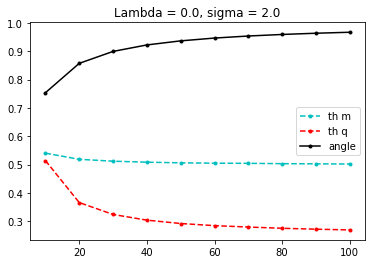

In [8]:
plt.plot(alpha_range, pr_m_list, 'c--',marker='.', label='th m')
plt.plot(alpha_range, pr_q_list, 'r--', marker='.', label='th q')

plt.plot(alpha_range, np.array(pr_m_list) / np.sqrt(np.array(pr_q_list)), 'k', marker='.', label='angle')

#plt.plot(alpha_range, pr_exp_m_list, 'c', marker='.', label='exp m')
#plt.plot(alpha_range, pr_exp_q_list, 'r', marker='.', label='exp q')

plt.title(f'Lambda = {lambda_}, sigma = {sigma}')
plt.legend()

In [49]:
# FOR LOGISTIC

alpha_range  = np.linspace(10.0, 100.0, 10)
sigma   = 2.0
lambda_ = 0.0

m_list, q_list, exp_m_list, exp_q_list = [], [], [], []

for alpha in alpha_range:
    print(alpha)
    
    theta, X, y = data.ProbitModelData(covariance = Omega, teacher_covariance = np.eye(d), sigma = sigma).sample_instance(alpha)
    
    task = LogisticRegression(sample_complexity = alpha,
                            regularisation    = lambda_,
                            data_model        = data_model,
                            Delta             = sigma**2)

    sp = StateEvolution(model = task,
                        initialisation = 'uninformed',
                        tolerance = 1e-5,
                        damping = 0.5,
                        verbose = False,
                        max_steps = 1000)

    sp.iterate()
    info = sp.get_info()
    print('done with se')
    
    m, q, rho = info['overlaps']['teacher_student'], info['overlaps']['self_overlap'], 1.0
    
    if lambda_ > 0.0:
        lr = linear_model.LogisticRegression('l2', C=1. / lambda_, fit_intercept=False)
    else:
        lr = linear_model.LogisticRegression('none', fit_intercept=False)
    lr.fit(X, y)
    weight = lr.coef_
    
    exp_m, exp_q = np.mean(theta * weight), np.mean(weight**2)

    m_list.append(m)
    q_list.append(q)
    exp_m_list.append(exp_m)
    exp_q_list.append(exp_q)    

10.0
done with se
20.0
done with se
30.0
done with se
40.0
done with se
50.0
done with se
60.0
done with se
70.0
done with se
80.0
done with se
90.0
done with se
100.0
done with se


In [9]:
plt.plot(alpha_range, m_list, 'c--',marker='.', label='th m')
plt.plot(alpha_range, q_list, 'r--', marker='.', label='th q')

# plt.plot(alpha_range, exp_m_list, 'c', marker='.', label='exp m')
# plt.plot(alpha_range, exp_q_list, 'r', marker='.', label='exp q')

plt.plot(alpha_range, np.array(m_list) / np.sqrt(np.array(q_list)), 'k', marker='.', label='Angle')

plt.title(f'Lambda = {lambda_}, sigma = {sigma}')
plt.legend()

NameError: name 'm_list' is not defined

### Some plots

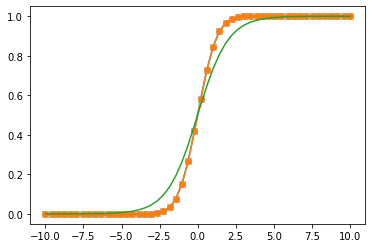

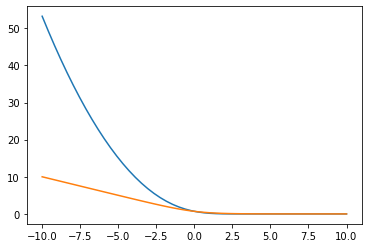

In [7]:
vals = np.linspace(-10.0, 10.0, 50)

def cdf(x):
    return 0.5 * erfc(- x / np.sqrt(2.0))

def approx_cdf(z):
    return 1.0 / (1.0 + 2*np.exp(-np.sqrt(2*np.pi)*z))

def logistic(x):
    return 1. / (1 + np.exp(-x))

def f_0(z):
    return - np.log( cdf(z) )

def f_1(z):
    return np.log(1 + np.exp(-z))

plt.plot(vals, cdf(vals), marker='x')
plt.plot(vals, norm.cdf(vals), marker='o')
plt.plot(vals, logistic(vals))
plt.show()

plt.plot(vals, f_0(vals))
plt.plot(vals, f_1(vals))
plt.show()

/var/folders/bh/679xzk357893hjh_yn8vw93h0000gq/T/ipykernel_61975/3151738842.py:5: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(vals2, norm.pdf(vals2) / cdf(-vals2)); plt.show()
/var/folders/bh/679xzk357893hjh_yn8vw93h0000gq/T/ipykernel_61975/3151738842.py:5: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(vals2, norm.pdf(vals2) / cdf(-vals2)); plt.show()


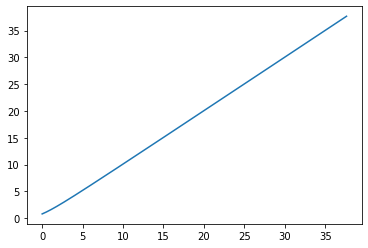

In [13]:
def d2loss(z):
    return (4*np.cosh(z/2)**2)

vals2 = np.linspace(0, 100, 1000)
plt.plot(vals2, norm.pdf(vals2) / cdf(-vals2)); plt.show()

nan 4.56986530030502


/var/folders/bh/679xzk357893hjh_yn8vw93h0000gq/T/ipykernel_47466/1727832809.py:14: RuntimeWarning: invalid value encountered in double_scalars
  return (x - omega) / V - y * gaussian(x) / cdf(x * y)
/var/folders/bh/679xzk357893hjh_yn8vw93h0000gq/T/ipykernel_47466/1727832809.py:17: RuntimeWarning: invalid value encountered in double_scalars
  return 1. / V -  y * (- x * gaussian(x) / cdf(x * y) - y * gaussian(x)**2 / cdf(x * y)**2)


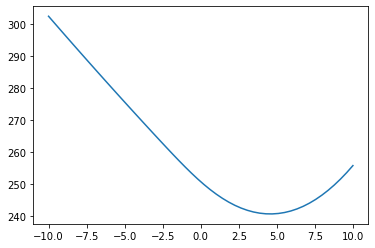

In [64]:
def gaussian(x, mean=0, var=1):
    return np.exp(-.5 * (x-mean)**2/var) / np.sqrt(2*np.pi*var)

def cdf(x):
    return 0.5 * erfc(- x / np.sqrt(2.0))

def loss(z):
    return - np.log( cdf(z) )

def moreau_loss(x, y, omega,V):
    return (x-omega)**2/(2*V) + loss(y*x)

def moreau_prime(x, y, omega, V):
        return (x - omega) / V - y * gaussian(x) / cdf(x * y)

def moreau_second(x, y, omega, V):
    return 1. / V -  y * (- x * gaussian(x) / cdf(x * y) - y * gaussian(x)**2 / cdf(x * y)**2)


omega = 100.0
V = 20.0
y = -1.0

root = root_scalar(lambda x : moreau_prime(x, y, omega, V),
                         fprime = lambda x : moreau_second(x, y, omega, V),
                         x0 = omega).root
mini = minimize_scalar(lambda x: moreau_loss(x, y, omega, V))['x']

plt.plot(vals, moreau_loss(vals, y, omega, V))

print(root, mini)